In [5]:
import pandas as pd
import math
import time
%matplotlib inline
import numpy as np
import pytz
from pytz import timezone
from pygeocoder import Geocoder
import numpy as np

import scipy.stats as stats
import matplotlib.pyplot as plt

df = pd.read_table('data/final_op.txt', index_col=None)
df['Is_Traffic_Related'] = df['Is_Traffic_Related'].map({'t': 1, 'f': 0})


In [7]:
df.head(2)

,tweet_id,tweet_text,tweet_coordinates,lat_origin,long_origin,uber_estimate,zip_code,eastern_time,hours,weekday,day_hour,Is_Traffic_Related,County,Neighbourhood,Neighbourhood_code,Is_weekend
0,8.324278e+17,Yeezus gospel #tbt @ Madison Square Garden htt...,"[40.75079924, -73.99297235]",40.750799,-73.992972,70,10001,2017-02-16 22:13:36-05,22,3,94,0,New York,Chelsea and Clinton,8,0
1,8.324278e+17,"GNW! @ New York, New York https://t.co/Sqpnij3q4k","[40.7142, -74.0064]",40.714200,-74.006400,79,10007,2017-02-16 22:13:40-05,22,3,94,0,Manhattan,Lower Manhattan,20,0


In [12]:
# Q1: What are the tweet counts by each County?
df1=df.groupby('County').size()
df1.sort_values(ascending=False)

County
Manhattan        6310
Brooklyn         1666
Queens            914
New York          667
Bronx             421
Staten Island       2
dtype: int64

In [14]:
# Q2: What are the tweet counts by each Neighbourhood an?
df1=df.groupby('Neighbourhood').size()
df1.sort_values(ascending=False)

Neighbourhood
Lower Manhattan                  2265
Chelsea and Clinton              1979
Greenwich Village and Soho        858
Gramercy Park and Murray Hill     368
Central Brooklyn                  360
Northwest Brooklyn                351
Lower East Side                   333
Upper West Side                   302
West Queens                       272
Inwood and Washington Heights     243
Upper East Side                   240
East Harlem                       228
Bushwick and Williamsburg         226
Jamaica                           218
Flatbush                          165
Central Harlem                    161
Southeast Bronx                   157
Sunset Park                       146
Greenpoint                        127
East New York and New Lots        118
West Central Queens               118
North Queens                       95
Central Bronx                      84
High Bridge and Morrisania         67
Central Queens                     67
Southern Brooklyn                  5

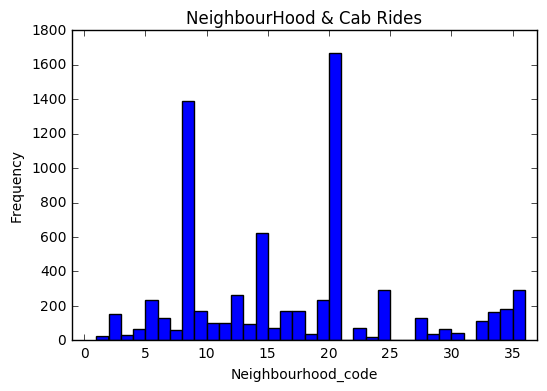

In [46]:
#plt.hist((df1.Neighbourhood_code)) 
binwidth = 1
plt.hist(df.Neighbourhood_code, bins=np.arange(min(df.Neighbourhood_code), max(df.Neighbourhood_code) + binwidth, binwidth))
plt.title("NeighbourHood & Cab Rides")
plt.xlabel("Neighbourhood_code")
plt.ylabel("Frequency")
plt.xlim([-1,37])
plt.show()

In [15]:
# Q3: How many data points do we have for weekends and weekdays?
df1=df.groupby('Is_weekend').size()
df1

Is_weekend
0    2779
1    7201
dtype: int64

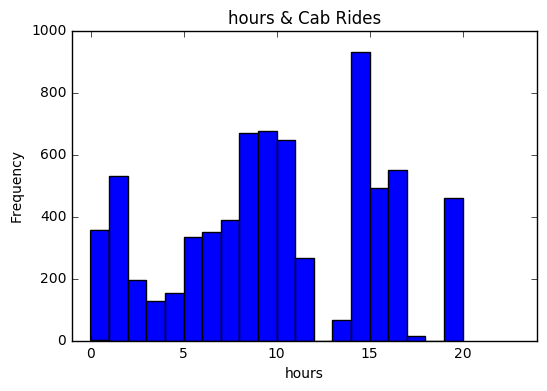

In [18]:
# Q4: Is there a good distribution of our data for different hours of week?
binwidth = 1
df= df[df.Is_weekend==1]
plt.hist(df.hours, bins=np.arange(min(df.hours), max(df.hours) + binwidth, binwidth))
plt.title("hours & Cab Rides")
plt.xlabel("hours")
plt.ylabel("Frequency")
plt.xlim([-1,24])
#major_ticks = np.arange(0, 36, 1)  
#plt.xticks(major_ticks)
plt.show()

(-1, 168)

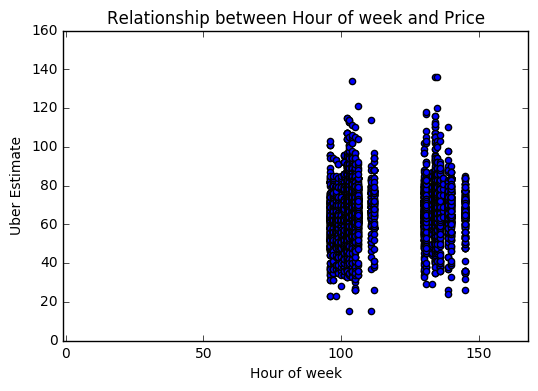

In [49]:
#Q Maybe just the time of day and whether its a weekend doesnt matter.
#The combination of both of the above can provide  a more interesting insight.
# For eg: 9pm on a friday night intuitively will have a higher demand than 9pm on Tuesday night. 
#Whereas 7 am Saturday will have less demand than 7am Monday.  

# Create a new independent variable which is a combination of hours and day. lets call it hour_of_week. What is the correlation 
#between hour_of_week and price?
plt.scatter(df.day_hour, df.uber_estimate)
plt.xlabel("Hour of week")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Hour of week and Price")
plt.xlim([-1,168])

In [43]:
# WHat are the most common words,#hastags and bag of words that appear in tweets? 
#which of these words can be used for analyis related to demand of cabs?

import time
import re
import pytz
from pytz import timezone
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
import string
from nltk import bigrams
from nltk import trigrams
import json

from unicodedata import normalize
 
punctuation = list(string.punctuation)
city_specific_stop_words =  ['York', 'Manhattan','NY','NewYork','NYC','The','A','#NewYork','#NYC','Brooklyn']
stop = stopwords.words('english') + punctuation + city_specific_stop_words + ['RT', 'rt', 'via', 'I' , 'like','\\',',',':','in','…','\ud83c','\ud83d','°','u2026','ud83d','ud83c']

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
        
    )"""


regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]


tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

count_all = Counter()

#twitter_dataset = pd.read_table('tweets_streamed_dataset.txt', index_col=None)
twitter_dataset = pd.read_table('data/final_op.txt', index_col=None)

for tweet in twitter_dataset.tweet_text:
    tweet = normalize('NFKD', tweet)
    terms_hash = [term for term in preprocess(tweet) if term.startswith('#')]
    count_all.update(terms_hash)
print ("\nHastags\n")
print(count_all.most_common(20))

print ("\n\nCommonWords\n\n")
for tweet in twitter_dataset.tweet_text:
    tweet = normalize('NFKD', tweet)
    terms_stop = [term for term in preprocess(tweet) if (term not in stop and not term.startswith(('#', '@')) and not emoji_pattern.search(term))]
    count_all.update(terms_stop)
print(count_all.most_common(20))

print ("\n\nTrigrams\n\n")

for tweet in twitter_dataset.tweet_text:
    tweet = normalize('NFKD', tweet)
    terms_stop = [term for term in preprocess(tweet) if (term not in stop and not term.startswith(('#', '@')) and not emoji_pattern.search(term))]
    terms_trigram = trigrams(terms_stop)
    count_all.update(terms_trigram)

print(count_all.most_common(30))


Hastags

[('#NewYork', 696), ('#job', 667), ('#Hiring', 546), ('#CareerArc', 436), ('#nyc', 277), ('#hiring', 252), ('#Job', 206), ('#diabetic', 202), ('#t1d', 202), ('#type1diabetes', 202), ('#diabetes', 202), ('#Jobs', 190), ('#NYC', 145), ('#I278', 118), ('#newyork', 115), ('#Hospitality', 84), ('#traffic', 78), ('#Repost', 78), ('#GrandCentralParkway', 70), ('#newyorkcity', 64)]


CommonWords


[('2026', 1957), ('New', 1797), ('n', 1435), ('th', 758), ('Street', 725), ('Incident', 709), ('#NewYork', 696), ('#job', 667), ('Avenue', 595), ('#Hiring', 546), ("I'm", 495), ('#CareerArc', 436), ('amp', 424), ('Update', 405), ('Station', 398), ('Exit', 391), ('Construction', 338), ('latest', 322), ('Cleared', 296), ('work', 295)]


Trigrams


[('2026', 1957), ('New', 1797), ('n', 1435), ('th', 758), ('Street', 725), ('Incident', 709), ('#NewYork', 696), ('#job', 667), ('Avenue', 595), ('#Hiring', 546), ("I'm", 495), ('#CareerArc', 436), ('amp', 424), ('Update', 405), ('Station', 398), ('

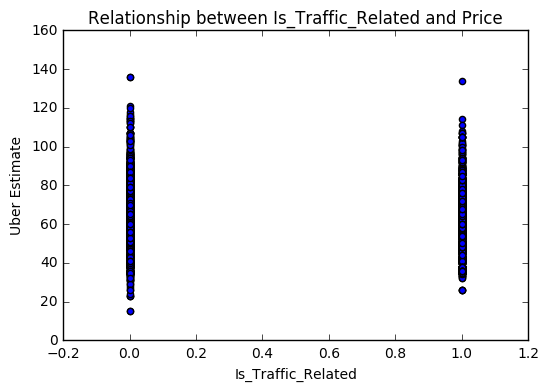

In [50]:
#bag_of_words = ['Construction','Ramp','Road','Incident','Accident','traffic','Friday','saturday','weekend', 'Terminal']
#Q - if these are identified as your initial bag of words, what is the correlation between the presence of these words and the price?
# should these features be tuned so that you get a better correlation?

plt.scatter(df.Is_Traffic_Related, df.uber_estimate)
plt.xlabel("Is_Traffic_Related")
plt.ylabel("Uber Estimate")
plt.title("Relationship between Is_Traffic_Related and Price")
#plt.xlim([-1,168])

Analysis
Our initial analysis shows that the bag of words identified to correlate tweets to traffic is not very informative about the relationship between tweets and the price prediction. We need to refine our feature vectors to better find out the terms which are indicative of our output variable which is price in this case.